In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
from scipy.integrate import solve_ivp
# numpy.linalg is also an option for even fewer dependencies

In [2]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [3]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [4]:
sol = solve_ivp(FHN, [0, 10000], [-0.1, 0.1, 0.1, 0.1], rtol = 1e-11, atol = 1e-11, dense_output=True)

In [6]:
train = sol.y[0][:21600]
test = sol.y[0][21600:] 

In [7]:
len(test)

6237

Computing spectral radius...
done.
MSE = 7.752614224105652e-09


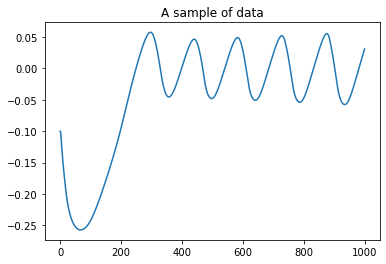

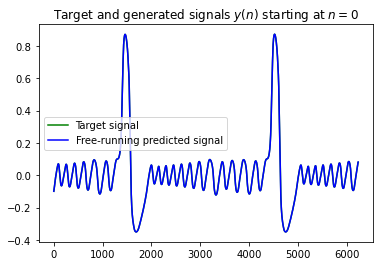

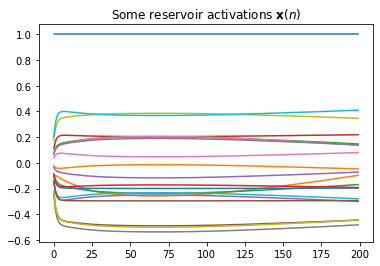

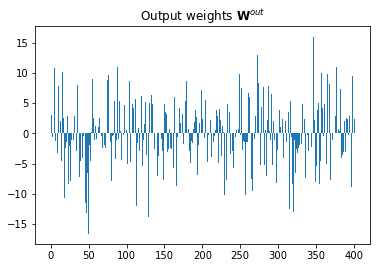

In [8]:


# load the data
trainLen = 21600
testLen = 6236
initLen = 0
data = sol.y[0]

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 400
a = 0.5 # leaking rate
np.random.seed(42)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5 
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 0.001 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh(np.dot(Win, np.vstack((1,u))) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
reservoir_end = x    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    #u = y
    ## this would be a predictive mode:
    u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()

In [9]:
from IPython.display import clear_output

In [16]:
#Y = np.zeros((outSize,testLen))
prediction = []
u = data[trainLen]
k = 20
x = reservoir_end
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    x_loop = x
    for j in range(k):
        y = np.dot( Wout, np.vstack((1,u,x_loop)) )
        
        # generative mode:
        u = y
        x_loop = (1-a)*x_loop + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x_loop ) )  
    prediction.append(y[0][0])
    ## this would be a predictive mode:
    u = data[trainLen+t+1] 

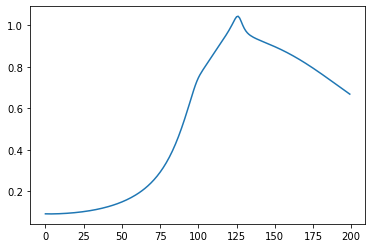

In [22]:
plt.plot(prediction[1300:1500])

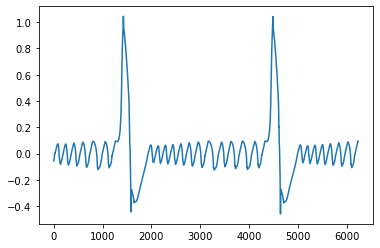

In [17]:
plt.plot(prediction)

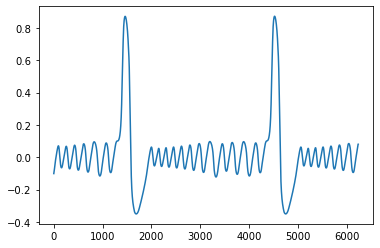

In [15]:
plt.plot(test)

In [9]:
Y.shape

(1, 4999)

In [11]:
np.save('RC_lienar', Y)

In [10]:
(((np.array(Y) - data[45001:])**2).mean())**0.5

0.17134487842168625

In [5]:
X

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.42399904,  0.42430433,  0.42459072, ...,  0.44758077,
         0.45033332,  0.4538997 ],
       [ 0.8923459 ,  0.89254202,  0.8927749 , ...,  0.89638721,
         0.89665346,  0.89697697],
       ...,
       [ 0.73307468,  0.73368373,  0.73441142, ...,  0.72954385,
         0.72973722,  0.72995825],
       [-0.00456642, -0.01124944, -0.01794039, ..., -0.08379933,
        -0.08506902, -0.08664056],
       [-0.60433966, -0.60708818, -0.60992258, ..., -0.64688467,
        -0.64700034, -0.64715967]])

In [6]:
Yt

array([[0.42430433, 0.42459072, 0.42485679, ..., 0.45033332, 0.4538997 ,
        0.45869201]])